## Ecommerce customer segementation 


## 0) Setup

### 0.a) Import packages


In [57]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import norm 
import os
import dateutil
import datetime as dt

import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#from sklearn.mixture import GMM

from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
import boto3, os, sagemaker
from sagemaker import get_execution_role

### 0.b) Get Amazon IAM execution role and instance region

In [5]:
# Define IAM role- this will be necessary when defining your model
iam_role = get_execution_role()

# set the region of the instance and get a reference to the client
my_region = boto3.Session().region_name

# sagemaker session handle
sm_session = sagemaker.session.Session(boto3.Session())

print("Success - the SageMaker instance is in the " + my_region + " region")

Success - the SageMaker instance is in the us-west-2 region


## 1) Load and examine data

In [8]:
bucket = "radybigdataproject"
prefix = "ecommerce"

In [38]:
dataset = pd.read_csv("s3://{}/{}/merged_training_dataset.zip".format(bucket,prefix))

In [39]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118315 entries, 0 to 118314
Data columns (total 43 columns):
order_id                         118315 non-null object
customer_id                      118315 non-null object
order_status                     118315 non-null object
order_purchase_timestamp         118315 non-null object
order_approved_at                118300 non-null object
order_delivered_carrier_date     117061 non-null object
order_delivered_customer_date    115727 non-null object
order_estimated_delivery_date    118315 non-null object
quantity                         118315 non-null int64
product_id                       118315 non-null object
seller_id                        118315 non-null object
shipping_limit_date              118315 non-null object
product_price                    118315 non-null float64
freight_value                    118315 non-null float64
payment_sequential               118315 non-null int64
payment_type                     118315 non-null 

In [40]:
dataset.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,quantity,product_id,seller_id,shipping_limit_date,product_price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,seller_zip_code_prefix,seller_city,seller_state,seller_lat,sellet_lng,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13T08:59:02Z,2017-09-13T09:45:35Z,2017-09-19T18:34:16Z,2017-09-20T23:43:48Z,2017-09-29T00:00:00Z,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19T09:45:35Z,58.90,13.29,1,credit_card,2,72.19,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21T00:00:00Z,2017-09-22T10:57:03Z,27277,volta redonda,SP,-22.498183,-44.123614,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26T10:53:06Z,2017-04-26T11:05:13Z,2017-05-04T14:35:00Z,2017-05-12T16:04:24Z,2017-05-15T00:00:00Z,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03T11:05:13Z,239.90,19.93,1,credit_card,3,259.83,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop,7b07bacd811c4117b742569b04ce3580,4,NaN,NaN,2017-05-13T00:00:00Z,2017-05-15T11:34:13Z,3471,sao paulo,SP,-23.566258,-46.518417,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,-20.212393,-50.941471
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14T14:33:31Z,2018-01-14T14:48:30Z,2018-01-16T12:36:48Z,2018-01-22T13:19:16Z,2018-02-05T00:00:00Z,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18T14:48:30Z,199.00,17.87,1,credit_card,5,216.87,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,furniture_decor,0c5b33dea94867d1ac402749e5438e8b,5,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23T00:00:00Z,2018-01-23T16:06:31Z,37564,borda da mata,MG,-22.264094,-46.158564,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.860439,-44.597972
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08T10:00:35Z,2018-08-08T10:10:18Z,2018-08-10T13:28:00Z,2018-08-14T13:32:39Z,2018-08-20T00:00:00Z,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15T10:10:18Z,12.99,12.79,1,credit_card,2,25.78,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumery,f4028d019cb58564807486a6aaf33817,4,NaN,NaN,2018-08-15T00:00:00Z,2018-08-15T16:39:01Z,14403,franca,SP,-20.548228,-47.395897,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,-23.144923,-46.539830
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04T13:57:51Z,2017-02-04T14:10:13Z,2017-02-16T09:46:09Z,2017-03-01T16:42:31Z,2017-03-17T00:00:00Z,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13T13:57:51Z,199.90,18.14,1,credit_card,3,218.04,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,garden_tools,940144190dcba6351888cafa43f3a3a5,5,NaN,Gostei pois veio no prazo determinado .,2017-03-02T00:00:00Z,2017-03-03T10:54:59Z,87900,loanda,PR,-22.931427,-53.133759,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,-23.249008,-46.824961
5,00048cc3ae777c65dbb7d2a0634bc1ea,816cbea969fe5b689b39cfc97a506742,delivered,2017-05-15T21:42:34Z,2017-05-17T03:55:27Z,2017-05-17T11:05:55Z,2017-05-22T13:44:35Z,2017-06-06T00:00:00Z,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23T03:55:27Z,21.90,12.69,1,boleto,1,34.59,36.0,558.0,1.0,450.0,

In [41]:
len(dataset)

118315

## 2) cleaning the dataset

In [42]:
# canceled orders ( separate analysis on this)
cancelled_orders = dataset[dataset['order_status'] != 'delivered']
len(cancelled_orders)

2587

In [43]:
dataset.dropna(subset=[ 'order_delivered_customer_date', 'order_delivered_carrier_date', 'order_approved_at', 'seller_lat', 'customer_lat', 'product_category'],inplace=True)
len(dataset)

113494

In [44]:
dataset= dataset[dataset['order_status'] == 'delivered']


In [45]:
len(dataset)

113487

In [46]:
# converting into date time objects

dataset.order_purchase_timestamp = pd.to_datetime(dataset.order_purchase_timestamp)
#dataset.order_aproved_at = pd.to_datetime(dataset.order_aproved_at)
dataset.order_estimated_delivery_date = pd.to_datetime(dataset.order_estimated_delivery_date)
dataset.order_delivered_customer_date = pd.to_datetime(dataset.order_delivered_customer_date)
dataset.review_creation_date = pd.to_datetime(dataset.review_creation_date)
dataset.review_answer_timestamp = pd.to_datetime(dataset.review_answer_timestamp)
dataset.product_category.replace(['None', 'NaN', np.nan], "NIL", inplace=True)

## 3) Exploratory analysis

In [56]:
# initialstatistics
dataset.describe()

,quantity,product_price,freight_value,payment_sequential,payment_installments,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,seller_zip_code_prefix,seller_lat,sellet_lng,customer_zip_code_prefix,customer_lat,customer_lng
count,113487.000000,113487.000000,113487.000000,113487.000000,113487.000000,113487.000000,113487.000000,113487.000000,113487.000000,113486.000000,113486.000000,113486.000000,113486.000000,113487.000000,113487.000000,113487.000000,113487.000000,113487.000000,113487.000000,113487.000000
mean,1.197758,120.039303,20.002700,1.090821,2.944857,172.194814,48.788998,784.854115,2.201239,2106.807298,30.283374,16.626112,23.096250,4.067056,24524.990281,-22.795858,-47.250479,35005.137478,-21.240403,-46.200271
std,0.704158,182.630517,15.740806,0.686121,2.780795,266.534302,10.020362,651.237507,1.713381,3763.313942,16.151381,13.450834,11.715415,1.357977,27649.347240,2.704538,2.346095,29837.754352,5.566872,4.046999
min,1.000000,0.850000,0.000000,1.000000,0.000000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000,1001.000000,-36.605374,-64.283946,1003.000000,-36.605374,-72.666706
25%,1.000000,39.900000,13.080000,1.000000,1.000000,60.860000,42.000000,345.000000,1.000000,300.000000,18.000000,8.000000,15.000000,4.000000,6429.000000,-23.611872,-48.831547,11250.000000,-23.590582,-48.110471
50%,1.000000,74.900000,16.310000,1.000000,2.000000,108.000000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,5.000000,13720.000000,-23.420739,-46.755211,24240.000000,-22.929319,-46.632051
75%,1.000000,133.000000,21.190000,1.000000,4.000000,189.370000,57.000000,982.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,5.000000,27930.000000,-21.766477,-46.518082,58345.000000,-20.199173,-43.630620
max,21.000000,6735.000000,409.680000,26.000000,24.000000,13664.080000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,5.000000,99730.000000,-2.546079,-34.847856,99980.000000,42.184003,-8.577855


In [48]:
# distribution of payments
payment_type = dataset.groupby('payment_type')[['payment_value', 'review_score']].agg({'review_score': ['mean'], 'payment_value':['sum','count']})

In [49]:
payment_type

review_score payment_value       
                     mean           sum  count
payment_type                                  
boleto           4.060443  3.892891e+06  22087
credit_card      4.068030  1.501601e+07  83728
debit_card       4.200615  2.423457e+05   1625
voucher          4.041839  3.906217e+05   6047

In [58]:
## customer order by month
dataset['customer_order_month'] = pd.DatetimeIndex(dataset['order_purchase_timestamp']).month
month_type = dataset.groupby('customer_order_month')[['payment_value', 'review_score']].agg({'review_score': ['mean'], 'payment_value':['sum','count']})

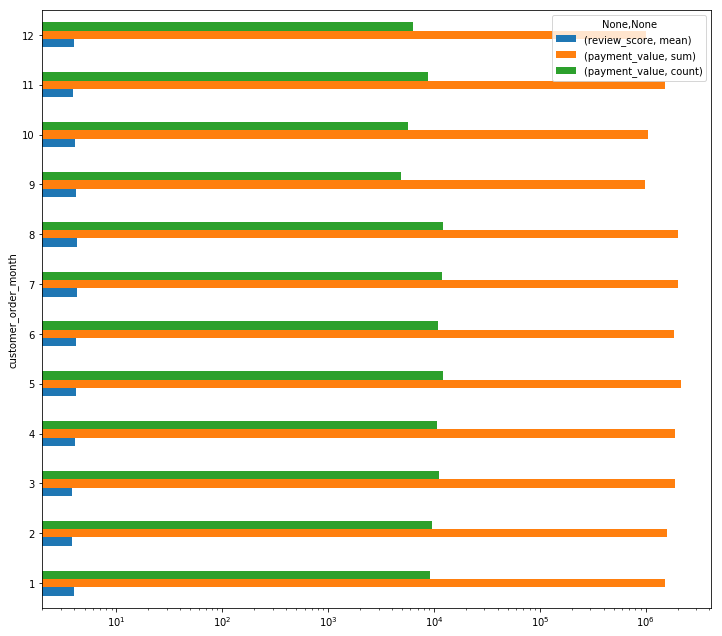

In [59]:
mp=month_type.plot(kind='barh', figsize=(12,11),logx=True)
mp

<Figure size 288x288 with 0 Axes>

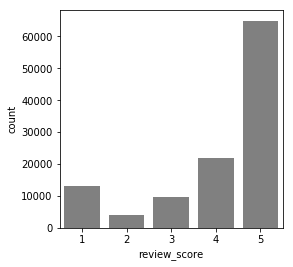

In [63]:
## review score distribution
review_scores=dataset.groupby('review_score').aggregate({'order_id':'count'}).rename(columns={'order_id':'count'}).sort_values(by='count',ascending=False).reset_index()
plt.figure(figsize=(4,4))
plt.title('Review score distribution')
sb.barplot(x=review_scores['review_score'],y=review_scores['count'],color="grey")

<Figure size 1008x1008 with 0 Axes>

Text(0.5, 1.0, 'Review score distribution Category wise')

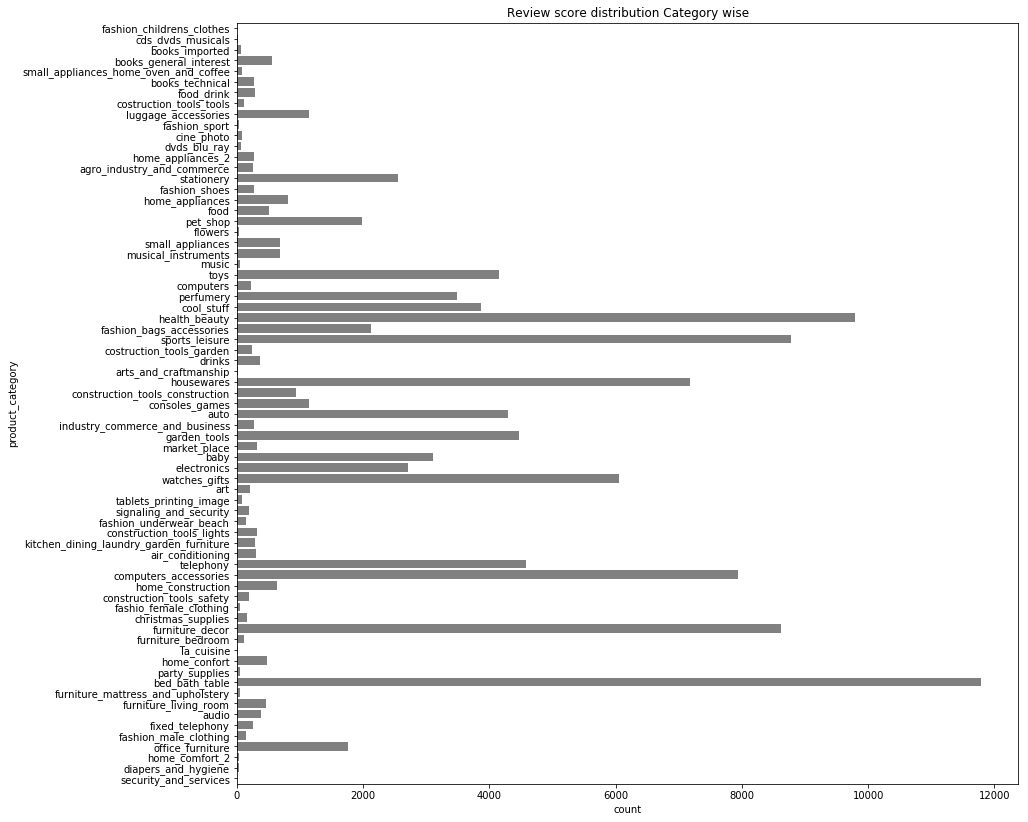

In [64]:
## By category review score
product_category=dataset.groupby('product_category')[['order_id', 'review_score']].agg({'review_score': ['mean'],'order_id':['count']}).sort_values(by=('review_score','mean'), ascending=False).reset_index()
plt.figure(figsize=(14,14))
plt.title('Review score distribution Category wise')
f=sb.barplot(x=product_category['order_id']['count'],y=product_category['product_category'],color="grey")

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Customers Per State')

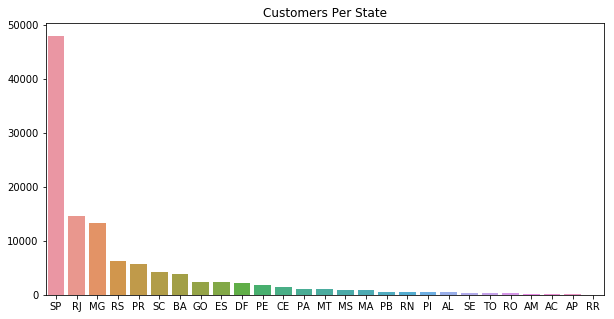

In [65]:
# customers per state
plt.figure(figsize=(10,5))
plt.title('Customers Per State')
sb.barplot(x=dataset['customer_state'].value_counts().index,y=dataset['customer_state'].value_counts().values)

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Sellers Per State')

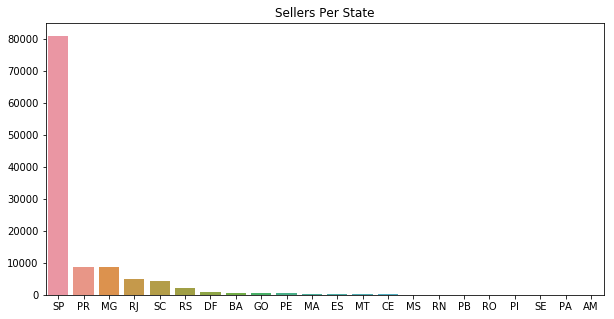

In [67]:
## sellers per state
plt.figure(figsize=(10,5))
plt.title('Sellers Per State')
sb.barplot(x=dataset['seller_state'].value_counts().index,y=dataset['seller_state'].value_counts().values)

In [69]:
# orders by year
dataset['year']=dataset['order_purchase_timestamp'].dt.year
dataset['month']=dataset['order_purchase_timestamp'].dt.month
total_orders_2017 = dataset[dataset['year']== 2017].groupby(['month']).size().reset_index(name='total_orders')
total_orders_2018 = dataset[dataset['year']== 2018].groupby(['month']).size().reset_index(name='total_orders')
total_orders_2016 = dataset[dataset['year']== 2016].groupby(['month']).size().reset_index(name='total_orders')

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Orders by month in 2017')

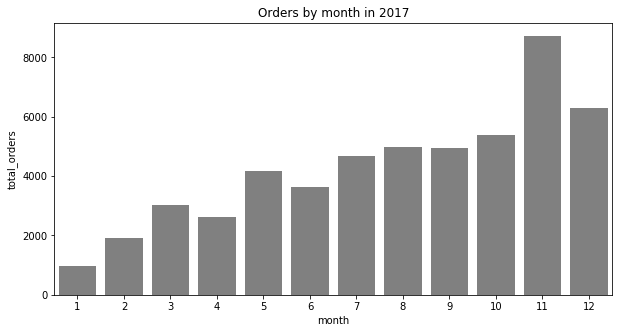

In [76]:
plt.figure(figsize=(10,5))
plt.title('Orders by month in 2017')
sb.barplot(x=total_orders_2017['month'],y=total_orders_2017['total_orders'],color="grey")


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Orders by month in 2018')

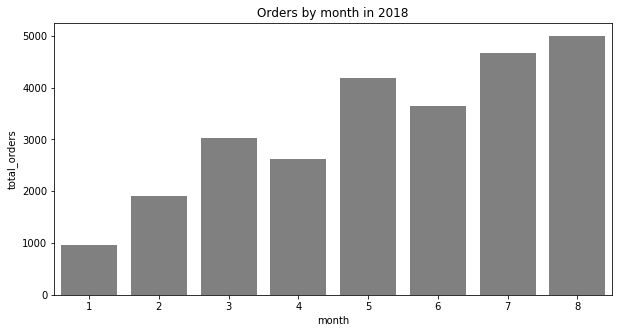

In [77]:
plt.figure(figsize=(10,5))
plt.title('Orders by month in 2018')
sb.barplot(x=total_orders_2018['month'],y=total_orders_2017['total_orders'],color="grey")


<Figure size 360x360 with 0 Axes>

Text(0.5, 1.0, 'Orders by month in 2016')

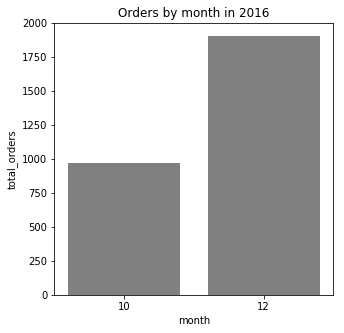

In [75]:
plt.figure(figsize=(5,5))
plt.title('Orders by month in 2016')
sb.barplot(x=total_orders_2016['month'],y=total_orders_2017['total_orders'], color="grey")


In [54]:
## correlation matrix
cor_df = dataset[['quantity','product_price', 'freight_value', 'product_description_lenght','product_weight_g','payment_installments', 'product_name_lenght','product_photos_qty','product_length_cm', 'product_height_cm', 'product_width_cm','payment_value', 'review_score']]
cor_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113487 entries, 0 to 118314
Data columns (total 13 columns):
quantity                      113487 non-null int64
product_price                 113487 non-null float64
freight_value                 113487 non-null float64
product_description_lenght    113487 non-null float64
product_weight_g              113486 non-null float64
payment_installments          113487 non-null int64
product_name_lenght           113487 non-null float64
product_photos_qty            113487 non-null float64
product_length_cm             113486 non-null float64
product_height_cm             113486 non-null float64
product_width_cm              113486 non-null float64
payment_value                 113487 non-null float64
review_score                  113487 non-null int64
dtypes: float64(10), int64(3)
memory usage: 17.1 MB


<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Correlation matrix')

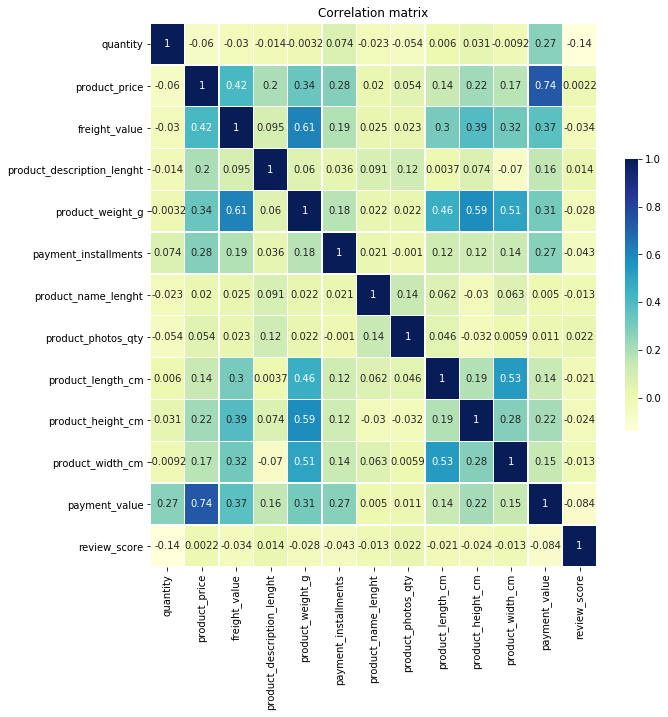

In [66]:
cor = cor_df.corr()
plt.figure(figsize=(10,10))
plt.title('Correlation matrix')
sb.heatmap(cor, annot=True, fmt=".2g",linewidths=0.4,cmap="YlGnBu",cbar_kws={"shrink": .5})

## 4.a) create new varaibles (R,F,M)--- Taking R,F,M as numbers

In [78]:
## creating recency scores
recency_scores = dataset.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
recency_scores.columns = ['customer_unique_id', 'MaxPurchaseDate']
recency_scores['Recency'] = (recency_scores['MaxPurchaseDate'].max() - recency_scores['MaxPurchaseDate']).dt.days
   

In [79]:
recency_scores.head()

,customer_unique_id,MaxPurchaseDate,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27+00:00,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27+00:00,114
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03+00:00,536
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41+00:00,320
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42+00:00,287


In [81]:
## creating frequency scores
frequency_scores = dataset.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
frequency_scores.columns = ['customer_unique_id','Frequency']

In [82]:
frequency_scores.head()

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [85]:
## creating monetory scores
monetory_scores = dataset.groupby('customer_unique_id').payment_value.sum().reset_index()
monetory_scores.columns = ['customer_unique_id','Monetary']

In [86]:
monetory_scores.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


In [88]:
## creating rfm data frame - combing recency frequency monetory scores
df_rfm = pd.merge(recency_scores, frequency_scores, on='customer_unique_id')
df_rfm = pd.merge(df_rfm, monetory_scores, on='customer_unique_id')
df_rfm.head()

,customer_unique_id,MaxPurchaseDate,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27+00:00,111,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27+00:00,114,1,27.19
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03+00:00,536,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41+00:00,320,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42+00:00,287,1,196.89


In [93]:
## standardizing the data
rfm_r_log = np.log(df_rfm['Recency']+0.001) #can't take log(0) and so adding a small number when the recency is 0
rfm_f_log = np.log(df_rfm['Frequency'])
rfm_m_log = np.log(df_rfm['Monetary']+0.001) #can't take log(0) and so adding a small number when the recency is 0
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})

In [90]:
log_data.head()

,Monetary,Recency,Frequency
0,4.955130,4.709539,0.0
1,3.302886,4.736207,0.0
2,4.456914,6.284136,0.0
3,3.775539,5.768324,0.0
4,5.282650,5.659486,0.0


In [91]:
len(log_data)

91610

## 5) Clustering Model

# run k means on rfm scores & return array of clusters numbers
# assign these cluster number back to each customer unique id

